In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from numba import njit, jit, prange, set_num_threads, get_num_threads
import scipy as sp
import time
import sys
import os
from EPRsimfcts import *
from matplotlib.cm import ScalarMappable
from joblib import Parallel, delayed


# Add both the Code directory and its parent to Python path
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

for path in [current_dir, parent_dir]:
    if path not in sys.path:
        sys.path.insert(0, path)  # Insert at beginning of path
# Optional: Visualize the points


## spin-spin coupling strength calculation

In [2]:
#Plotting the strength of dipole-dipole interaction vs. the orientation of EYFP in lab frame
N_mesh = 100
phi_01=np.linspace(0, 2 * np.pi, N_mesh) 
chi_01 = np.linspace(0, 2 * np.pi, N_mesh) 
#cos_theta_01 = np.random.uniform(-1, 1)   # Cosine of polar angle
cos_theta_01 = np.linspace(-1, 1, N_mesh)
theta_01 = np.arccos(cos_theta_01) 
theta_12 = np.pi/2*0 # Polar angle theta_12 is usually a fixed value for dumbbell model
phi_12 = np.pi/3*0 # Set phi_12=0 for simplicity; but occasionally it is not)

V = 52.16/1000 # Hss coefficient, unit: 2pi*GHz*nm^3
d=2 # distance, unit: nm

In [3]:
D0 = 2.348 #GHz
E0 = 0.458 #GHz
B0 = 0.03 # T
Delta1 = np.zeros([N_mesh, N_mesh])*(0+0j)
Delta2 = np.zeros([N_mesh, N_mesh])*(0+0j)
Delta3 = np.zeros([N_mesh, N_mesh])*(0+0j)
Txz = np.zeros([N_mesh, N_mesh])
Tyz = np.zeros([N_mesh, N_mesh])
Txy = np.zeros([N_mesh, N_mesh])
for i in range(N_mesh):
    for j in range(N_mesh):
        H_0 = H0(D0, E0, B0, 0.0, theta_01[i], chi_01[j])
        E_0, M0=np.linalg.eigh(H_0)
        Txz[i, j]=E_0[2]-E_0[0]
        Tyz[i, j]=E_0[1]-E_0[0]
        Txy[i, j]=E_0[2]-E_0[1]
        eigvec=M0.T
        #print(E_0, M0)
        #Delta = [0, 0, 0]
        for q in [-1, 0, 1]:
        #for q in [0]:
            if q==-1:
                TS = T1mS(1)
            elif q==0:
                TS = T10S(1)
            elif q==1:
                TS = T1pS(1)
            #print (eigvec[0].conj())
            coef = C_q(q, theta_01[i], chi_01[j], theta_12, phi_12)
            Mat_prod1=eigvec[0].conj()@np.matmul(TS, eigvec[0])
            Mat_prod2=eigvec[1].conj()@np.matmul(TS, eigvec[1])
            Mat_prod3=eigvec[2].conj()@np.matmul(TS, eigvec[2])
            #print(f"{theta_01[i]:.2f}", q, f"{coef:.4f}", f"{Mat_prod1:.4f}", f"{Mat_prod2:.4f}", f"{Mat_prod3:.4f}",)
            Delta1[i, j]=Delta1[i, j]+coef*Mat_prod1
            Delta2[i,j]=Delta2[i,j]+coef*Mat_prod2
            Delta3[i,j]=Delta3[i,j]+coef*Mat_prod3
        if np.abs(Delta1[i,j])<1e-10:
            Delta1[i,j]=0
        if np.abs(Delta2[i,j])<1e-10:
            Delta2[i,j]=0
        if np.abs(Delta3[i,j])<1e-10:
            Delta3[i,j]=0
        #print(f"{V/d**3*Delta1[i,j].real:.4f}", f"{V/d**3*Delta2[i, j].real:.4f}", f"{V/d**3*Delta3[i, j].real:.4f}")
            
Delta1= V/d**3*Delta1
Delta2= V/d**3*Delta2
Delta3= V/d**3*Delta3

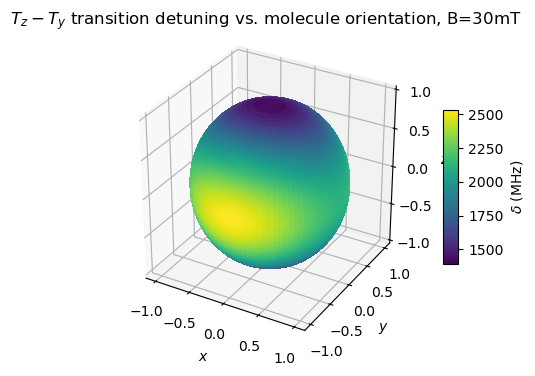

In [4]:


# Step 1: Define the grid in spherical coordinates
theta, chi = np.meshgrid(theta_01, chi_01)

# Step 2: Compute Cartesian coordinates for the unit sphere
x = np.sin(theta) * np.cos(chi)
y = np.sin(theta) * np.sin(chi)
z = np.cos(theta)
F = (Tyz.T)*1000
#F = (Txz.T)*1000 #For calculating Tz-Tx transition
#Ave Tz-Ty: 2.0117916
F_norm = (F - F.min()) / (F.max() - F.min())
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111, projection='3d')
#x,y,z=np.sin(theta_01)*np.cos(chi_01), np.sin(theta_01)*np.sin(chi_01), np.cos(theta_01), 
# Plot the surface and use the colormap to set face colors based on F_norm
surf = ax.plot_surface(
    x, y, z, 
    facecolors=plt.cm.viridis(F_norm), 
    rstride=1, cstride=1, 
    linewidth=0, antialiased=False, shade=False
)

# Step 4: Add a colorbar
mappable = ScalarMappable(cmap='viridis')
mappable.set_array(F)
fig.colorbar(mappable, ax=ax, shrink=0.5, aspect=10, label=r'$\delta$ (MHz)')

# Setting labels and title
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.set_zlabel(r'$z$')
ax.set_box_aspect([1,1,1])  # Ensure equal scaling

plt.title(r"$T_z-T_y$ transition detuning vs. molecule orientation, B=30mT")
plt.show()

Text(0.5, 0, '$\\Delta_x$ (MHz)')

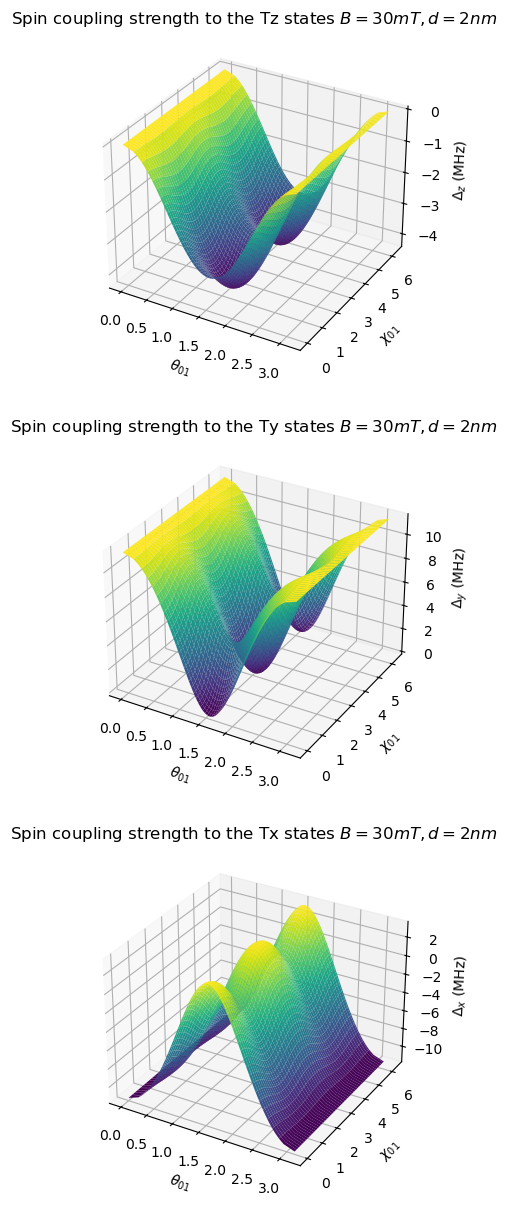

In [5]:
fig = plt.figure(figsize=(10,15))  # Create a figure
ax1 = fig.add_subplot(311, projection='3d')  # Add 3D axes
ax2 = fig.add_subplot(312, projection='3d')  # Add 3D axes
ax3 = fig.add_subplot(313, projection='3d')  # Add 3D axes
x,y = np.meshgrid(theta_01, chi_01)
#ax1.set_title(r'$B=0mT, d = 2nm, \theta=0, \phi=0$')
ax1.set_title(r'Spin coupling strength to the Tz states $B=30mT, d = 2nm$')
ax1.plot_surface(x,y, (Delta1.T).real*1000, cmap='viridis') #Coupling strength between radical spin and the Tz state
ax1.set_xlabel(r'$\theta_{01}$')
ax1.set_ylabel(r'$\chi_{01}$')
ax1.set_zlabel(r'$\Delta_z$ (MHz)')
#ax1.set_zlim([-1, 1])
ax2.set_title(r'Spin coupling strength to the Ty states $B=30mT, d = 2nm$')
ax2.plot_surface(x,y, (Delta2.T).real*1000, cmap='viridis') #Coupling strength between radical spin and the Ty state
ax2.set_xlabel(r'$\theta_{01}$')
ax2.set_ylabel(r'$\chi_{01}$')
ax2.set_zlabel(r'$\Delta_y$ (MHz)')
#ax2.set_zlim([-1, 1])
ax3.set_title(r'Spin coupling strength to the Tx states $B=30mT, d = 2nm$')
ax3.plot_surface(x,y, (Delta3.T).real*1000, cmap='viridis') #Coupling strength between radical spin and the Tx state
ax3.set_xlabel(r'$\theta_{01}$')
ax3.set_ylabel(r'$\chi_{01}$')
ax3.set_zlabel(r'$\Delta_x$ (MHz)')
#ax3.set_zlim([-1, 1])
#ax1.legend()

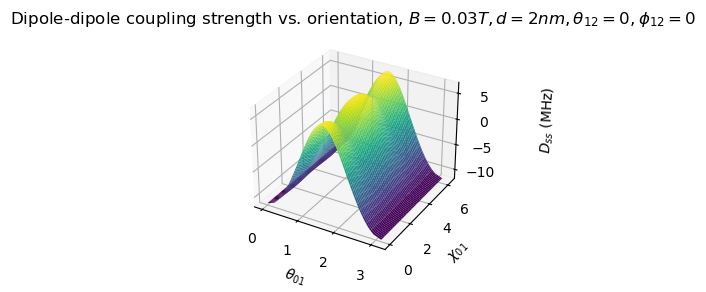

In [6]:
fig = plt.figure(figsize=(3,4))  # Create a figure
ax1 = fig.add_subplot(111, projection='3d')  # Add 3D axes
x, y = np.meshgrid(theta_01, chi_01)
ax1.set_title(r'Dipole-dipole coupling strength vs. orientation, $B=0.03T, d = 2nm, \theta_{12}=0, \phi_{12}=0$')
ax1.plot_surface(x,y, ((Delta3.T).real*1000-(Delta1.T).real*1000), cmap='viridis') #Dss 
ax1.set_xlabel(r'$\theta_{01}$')
ax1.set_ylabel(r'$\chi_{01}$')
ax1.set_zlabel(r'$D_{ss}$ (MHz)', labelpad=20)
ax1.zaxis.label.set_position((3, 6, 0))

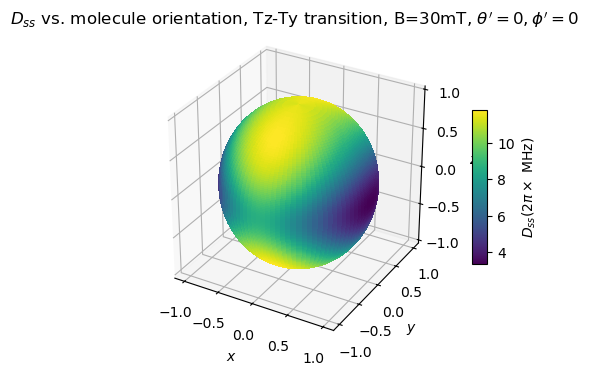

In [6]:

# Step 1: Define the grid in spherical coordinates
theta, chi = np.meshgrid(theta_01, chi_01)

# Step 2: Compute Cartesian coordinates for the unit sphere
x = np.sin(theta) * np.cos(chi)
y = np.sin(theta) * np.sin(chi)
z = np.cos(theta)
F = ((Delta2.T).real*1000-(Delta1.T).real*1000).real
F_norm = (F - F.min()) / (F.max() - F.min())
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111, projection='3d')
#x,y,z=np.sin(theta_01)*np.cos(chi_01), np.sin(theta_01)*np.sin(chi_01), np.cos(theta_01), 
# Plot the surface and use the colormap to set face colors based on F_norm
surf = ax.plot_surface(
    x, y, z, 
    facecolors=plt.cm.viridis(F_norm), 
    rstride=1, cstride=1, 
    linewidth=0, antialiased=False, shade=False
)

# Step 4: Add a colorbar
mappable = ScalarMappable(cmap='viridis')
mappable.set_array(F)
fig.colorbar(mappable, ax=ax, shrink=0.5, aspect=10, label=r'$D_{ss} (2\pi\times$ MHz)')

# Setting labels and title
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.set_zlabel(r'$z$')
ax.set_box_aspect([1,1,1])  # Ensure equal scaling

plt.title(r"$D_{ss}$ vs. molecule orientation, Tz-Ty transition, B=30mT, $\theta'=0, \phi'=0$")
plt.show()

## Simulation for DEER signal

In [7]:
N_mol = 10000 #Total molecule number
phi_01, theta_01, chi_01=Generate_molecule_set(N_mol)

theta_12 = 0 # Polar angle theta_12 is usually a fixed value for dumbbell model
phi_12 = 0 # Set phi_12=0 for simplicity; but generally it is not)

V = 52.16/1000 # Hss coefficient, unit: 2pi*GHz*nm^3
d=2 # distance, unit: nm
D0 = 2.356 #GHz
E0 = 0.458 #GHz
B0 = 0.03 # T
Omega1=2*np.pi*50 #microwave strength for driving Rabi oscillation, MHz; equivalent to \gamma_B \times B_1 in the note
t_pi=0.011055 #pi pulse duration, unit: us, the value is defined from the Rabi oscillation part of this jupyter notebook

Txz,Tyz, deltaxz, deltayz, Rabi_freq_xz, Rabi_freq_yz, Dss_zx, Dss_zy, nx, ny, nz = Transitions_and_couplings_calculation_numba(B0, D0, E0, d, Omega1, phi_01, theta_01, chi_01, theta_12, phi_12)

### 4-pulse DEER on $T_z$ to $T_x$ transition

In [8]:
N_tau=201 #Time sequence resolution
tau_eyfp_1=0.05 # fix the tau value for EFYP in the 4-pulse DEER simulation, unit: us
tau_eyfp_2=2.0

10.293637990951538


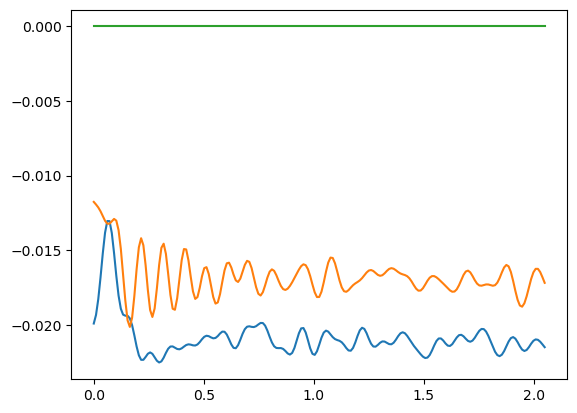

In [9]:
t0=time.time()
tau, sig_p, sig_m, sig_c=DEER_4_pulse_numba(Rabi_freq_xz, 0.011, Omega1, deltaxz, Dss_zx, tau_eyfp_1, tau_eyfp_2, N_tau, nz, nx)
print(time.time()-t0)

plt.plot(tau,sig_p) #The signal with the initial condition that the target spin state is m=1/2
plt.plot(tau,sig_m) #The signal with the initial condition that the target spin state is m=-1/2
plt.plot(tau,sig_c) #The signal without dipole-dipole coupling
#plt.ylim([0, 1])

In [ ]:
#DEER on Tz-Tx transition
tau, sig_p, sig_m, sig_c=DEER_4_pulse_numba(Rabi_freq_xz, 0.011, Omega1, deltaxz, Dss_zx, tau_eyfp_1, tau_eyfp_2, N_tau, nz, nx)

### 4-pulse DEER on $T_z$ to $T_y$ transition

In [ ]:
#DEER on Tz-Ty transition
tau, sig_p, sig_m, sig_c=DEER_4_pulse_numba(Rabi_freq_yz, 0.014, Omega1, deltayz, Dss_zy, tau_eyfp_1, tau_eyfp_2, N_tau, nz, ny)

Text(0, 0.5, 'Signal')

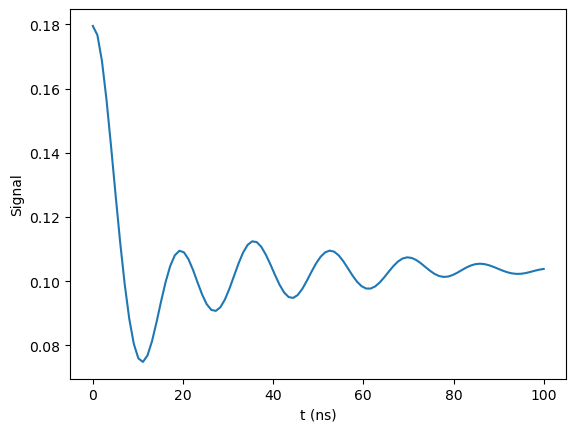

In [ ]:
#This cell is to compute the Rabi frequency
time_seq=np.linspace(0, 0.1, 100)

sig=np.zeros([len(time_seq)])*(1+0j)
sz=np.array([[1, 0],[0, -1]])*(1+0j)
scale_factor=1 #Varying the mw poer

for n_i in range(N_mol):
    rho0=np.array([[nx[n_i], 0],[0, nz[n_i]]])
    #rho0=np.array([[ny[n_i], 0],[0, nz[n_i]]])
    H_mol=Eff_H(Rabi_freq_xz[n_i]*scale_factor, deltaxz[n_i])
    #H_mol=Eff_H(Rabi_freq_yz[n_i]*scale_factor, deltayz[n_i])
    U_0=expm_hamiltonian(H_mol, time_seq[1])
    for t_i in range(len(time_seq)):
        #U_mol=sp.linalg.expm(-1j*H_mol*time_seq[t_i])
        #U_mol=np.linalg.matrix_power(U_0, t_i)
        U_mol=expm_hamiltonian(H_mol, time_seq[t_i])
        rho_i=U_mol@rho0@U_mol.conj().T
        #print(U_mol.trace())
        sig[t_i]+=np.trace(rho_i@sz)
plt.plot(time_seq*1000, np.real(sig)/N_mol)
plt.xlabel('t (ns)')
plt.ylabel('Signal')

In [ ]:
time_seq[np.argmin(sig)] #Determine the pi-pulse duration

np.float64(0.011111111111111112)

Text(0.5, 0, "$\\tau'(\\mu s)$")

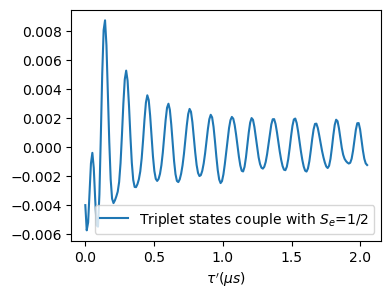

In [20]:
plt.figure(figsize=(4,3))
plt.plot(tau, (sig_p+sig_m)/2, label=r"Triplet states couple with ${S_e}$=1/2")
#plt.plot(tau, 1-sig_m, label=r"Triplet states couple with $m_{S_e}$=-1/2 state")
#plt.plot(tau, 1-sig_c, label=r"eYFP only (Spin $S_e$ removed)")
plt.legend()
plt.xlabel(r"$\tau'(\mu s)$")

## Using DEERLab package to analyze the DEER data

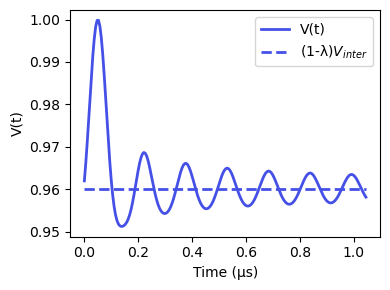

In [ ]:
import deerlab as dl


# Simulation parameters
tau1, tau2 = 0.05, 1 # Inter-pulse delays, µs
tmin = 0.0            # Start time, μs
Δt = 1.05/200            # Time increment, μs

rmean = 2.0           # Mean distance, nm
rstd = 1e-3           # Distance standard deviation, nm
rmin, rmax = 1.5, 5   # Range of the distance vector, nm
Δr = 0.05             # Distance increment, nm

conc = 0             # Spin concentration, μM
lam = 0.040            # Modulation depth
V0 = 1                # Overall echo amplitude

# Time vector
tmax = tau1+tau2
t = np.arange(tmin, tmax, Δt)

# Distance vector
r = np.arange(rmin, rmax, Δr)

# Construct the 4-pulse DEER model
Vmodel = dl.dipolarmodel(t, r, Pmodel=dl.dd_gauss)

# Simulate the signal with orientation selection
Vsim = Vmodel(mean=rmean, std=rstd, conc=conc, scale=V0, mod=lam, reftime=tau1)

# Scaled background (for plotting)
Vinter = V0*(1-lam)*dl.bg_hom3d(t-tau1, conc, lam)

# Plot the simulated signal
violet = '#4550e6'
plt.figure(figsize=[4,3])
plt.plot(t, Vsim, color=violet, lw=2, label='V(t)')
plt.plot(t, Vinter, '--', color=violet, lw=2, label='(1-λ)$V_{inter}$')
plt.legend()
plt.xlabel('Time (μs)')
plt.ylabel('V(t)')
plt.tight_layout()
plt.show()


In [39]:
Vexp=(sig_p+sig_m)/2
Vexp = (Vexp-np.min(Vexp))/(np.max(Vexp)-np.min(Vexp))   # Rescaling (aesthetic)
#t = t - t[0]                  # Account for zerotime
#t = t + tmin   
t=np.linspace(0, 2.05, 201) 
# Distance vector
r = np.arange(1.5,5.0,0.002) # nm

# Construct the model
Vmodel = dl.dipolarmodel(t,r, experiment = dl.ex_4pdeer(tau_eyfp_1,tau_eyfp_2, pathways=[1,2, 3,4]))

# Fit the model to the data
results = dl.fit(Vmodel,Vexp)

# Print results summary
print(results)

Goodness-of-fit: 
========= ============= ============== ===================== ======= 
 Dataset   Noise level    Reduced 𝛘2    Residual autocorr.    RMSD   
========= ============= ============== ===================== ======= 
   #1         0.041         14.252             1.794          0.149  
========= ============= ============== ===================== ======= 
Model hyperparameters: 
 Regularization parameter  
         989.165           
Model parameters: 
=========== ========== ========================= ====== ====================================== 
 Parameter   Value      95%-Confidence interval   Unit   Description                           
=========== ========== ========================= ====== ====================================== 
 lam1        6.29e-07   (0.00e+00,1.000)                 Amplitude of pathway #1               
 reftime1    0.098      (0.002,0.098)              μs    Refocusing time of pathway #1         
 lam2        1.50e-04   (0.00e+00,1.000)             

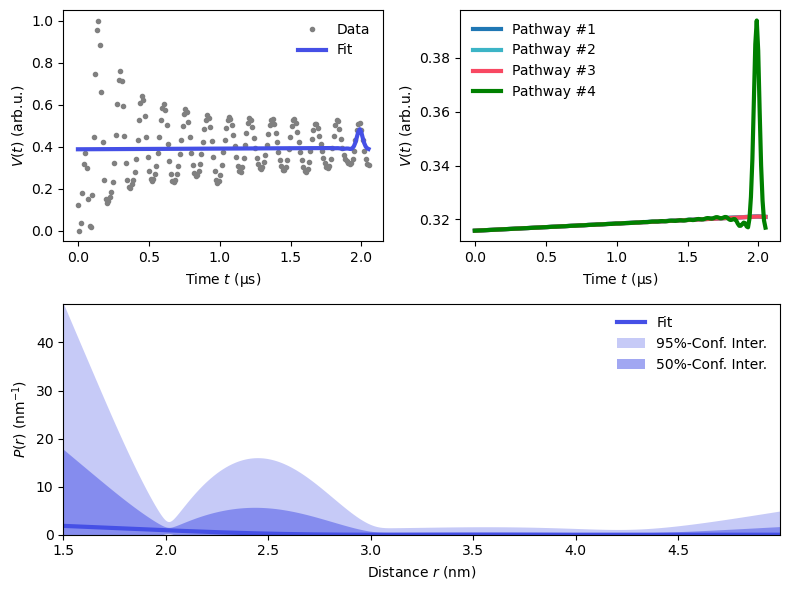

In [40]:
Vfit = results.model

# Extract fitted distance distribution
Pfit = results.P
Pci95 = results.PUncert.ci(95)
Pci50 = results.PUncert.ci(50)

plt.figure(figsize=[8,6])
violet = '#4550e6'
green = '#3cb4c6'
red = '#f84862'
plt.subplot(221)
# Plot experimental data
plt.plot(t,Vexp,'.',color='grey',label='Data')
# Plot the fitted signal
plt.plot(t,Vfit,linewidth=3,color=violet,label='Fit')
plt.legend(frameon=False,loc='best')
plt.xlabel('Time $t$ (μs)')
plt.ylabel('$V(t)$ (arb.u.)')

plt.subplot(222)
lams = [results.lam1, results.lam2, results.lam3, results.lam4]
reftimes = [results.reftime1, results.reftime2, results.reftime3, results.reftime4]
colors= ['tab:blue',green, red, 'g']
Vinter = results.P_scale*(1-np.sum(lams))*np.prod([dl.bg_hom3d(t-reftime,results.conc,lam) for lam,reftime in zip(lams,reftimes)],axis=0)
for n,(lam,reftime,color) in enumerate(zip(lams,reftimes,colors)):
    Vpath = (1-np.sum(lams) + lam*dl.dipolarkernel(t-reftime,r)@Pfit)*Vinter
    plt.plot(t,Vpath,linewidth=3,label=f'Pathway #{n+1}',color=color)
plt.legend(frameon=False,loc='best')
plt.xlabel('Time $t$ (μs)')
plt.ylabel('$V(t)$ (arb.u.)')

# Plot the distance distribution
plt.subplot(212)
plt.plot(r,Pfit,linewidth=3,color=violet,label='Fit')
plt.fill_between(r,Pci95[:,0],Pci95[:,1],alpha=0.3,color=violet,label='95%-Conf. Inter.',linewidth=0)
plt.fill_between(r,Pci50[:,0],Pci50[:,1],alpha=0.5,color=violet,label='50%-Conf. Inter.',linewidth=0)
plt.legend(frameon=False,loc='best')
plt.autoscale(enable=True, axis='both', tight=True)
plt.xlabel('Distance $r$ (nm)')
plt.ylabel('$P(r)$ (nm$^{-1}$)')

plt.tight_layout()
plt.show()
